# MST Vincolato
Dato un grafo non orientato e non completo, e dato un nodo r, si determini l’albero di copertura di radice r che minimizza il numero di figli di ogni nodo -1 (dato un albero di copertura, orientato a partire dalla radice, ogni nodo i non foglia ha ki ≥ 1 figli. Si minimizza la somma su tutti i nodi i non foglia di ki-1)

In [60]:
import os
import networkx as nx
import matplotlib.pyplot as plt

* inizializza grafo e strutture
    * 
* crea una soluzione ammissibile (es. con Kruskal)
* Migliora e imponi i vincoli con ricerca locale
    * aggiungi un arco all'MST
    * rimuovi un arco del ciclo che si è venuto a creare
    * calcola la nuova funzione obiettivo
        * pensa a fattori di penalizzazione per nodi con + figli?
    * ripeti :)
* 

### Inizializzazione

In [61]:
# PARAMETRI
DEBUG_IMPROVEMENT = False
OUT_DIR = os.path.join(os.getcwd(),"out") # dove salvare i disegni dei grafi (x debug)

if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)

In [62]:
MAX_NODES = 8

# TODO importa grafo da file

# Grafo di test
G = nx.Graph()
G.add_nodes_from([
    x for x in range(1, MAX_NODES+1)
])

G.add_edges_from([
    (x,y) for x in range(1, MAX_NODES+1)
          for y in range(x+1, MAX_NODES+1)
])

# Rendiamo il grafo non completo
G.remove_edges_from([ (1,4), (3,6), (5,3), (4,5) ])


In [63]:
# Alcune funzioni di supporto

def draw_graph(graph, MST=nx.empty_graph(), root_node=None):
    # adapted from:
    # https://stackoverflow.com/questions/60164893/highlighting-certain-nodes-edges-in-networkx-issues-with-using-zip

    #nx.draw_shell(graph, with_labels=True, font_weight='bold')
    #nx.draw_shell(MST, with_labels=True, font_weight='bold', edge_color='red')
    
    # Get position using spring layout
    #pos = nx.spring_layout(graph, seed=1234)
    pos = nx.circular_layout(graph)

    # Get MST path
    path_edges = list(MST.edges)


    # Draw nodes and edges not included in the MST path
    #nx.draw_networkx_nodes(graph, pos, nodelist=set(graph.nodes)-set(MST.nodes))
    nx.draw_networkx_nodes(graph, pos, nodelist=graph.nodes)
    nx.draw_networkx_edges(graph, pos, edgelist=set(graph.edges)-set(path_edges), edge_color='grey', connectionstyle='arc3, rad = 0.3')

    # Draw MST path
    # highlight the root node
    if root_node != None:
        nx.draw_networkx_nodes(graph, pos, nodelist=[root_node], node_color='yellow')

    nx.draw_networkx_edges(graph,pos,edgelist=path_edges, edge_color='r', connectionstyle='arc3, rad = 0.3')

    # Draw labels
    nx.draw_networkx_labels(graph,pos)



In [64]:
# Funzione obiettivo

def cost(MST, root_node, debug=False):

    support_graph = nx.Graph()

    visited = set()
    next = [root_node]
    
    cost = 0

    while len(next) > 0:
        node = next.pop(0)
        node_edges = MST.edges(node)
        
        if node not in visited:
            k_children = len( [ x for x in node_edges if x not in support_graph.edges ] )

            if debug:
                print("node {} has {} children".format(node, k_children))

            if k_children > 1:
                cost += k_children - 1

            visited.add(node)
            next = next + list(MST.adj[node])
            support_graph.add_edges_from(node_edges)
        
    return cost


node 1 has 2 children
node 2 has 3 children
node 6 has 0 children
node 3 has 0 children
node 5 has 0 children
node 4 has 0 children
cost:  3


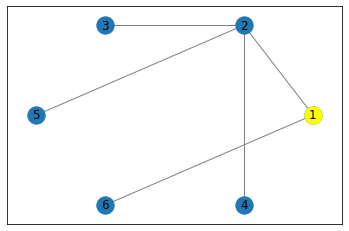

In [65]:
# TEST children nodes
TEST = nx.Graph()
TEST.add_edges_from([(1, 2), (2, 3), (2, 5), (1, 6), (2, 4)])

TEST_ROOT = 1

draw_graph(TEST, root_node=TEST_ROOT)

print("cost: ",cost(TEST, 1,debug=True))

## Ricerca Locale
1) crea una soluzione ammissibile (es. con Kruskal)
2) Migliora e imponi i vincoli con ricerca locale
    * aggiungi un arco all'MST
    * rimuovi un arco del ciclo che si è venuto a creare
    * calcola la nuova funzione obiettivo
        * pensa a fattori di penalizzazione per nodi con + figli?
    * ripeti :)

In [66]:
# PARAMETRI
ROOT_NODE=1

In [67]:
next_visit = list(G.adj[ROOT_NODE])

print("next_visit = ",next_visit)

for n in list(G.adj[2]):
    next_visit.append(n)

print("next_visit = ",next_visit)

node = next_visit.pop(0) # pop()  = estrazione LIFO (STACK), 
                         # pop(0) = estrazione FIFO (CODA)
print("node =",node)
next_visit.insert(0, "ciao")
print("next_visit = ",next_visit)



[x for x in range(0,12) if x%2 == 0]


next_visit =  [2, 3, 5, 6, 7, 8]
next_visit =  [2, 3, 5, 6, 7, 8, 1, 3, 4, 5, 6, 7, 8]
node = 2
next_visit =  ['ciao', 3, 5, 6, 7, 8, 1, 3, 4, 5, 6, 7, 8]


[0, 2, 4, 6, 8, 10]

### 1. Creazione soluzione ammissibile

Parto da un MST subottimale ottenuto con la visita in ampiezza a partire dalla radice.

> TODO: usare Kruskal/Prim e poi invertire gli archi entranti nel nodo radice per "raddrizzare" l'albero?

In [68]:
# Creazione di MST ammissibile a partire dal nodo radice specificato
# tramite visita in ampiezza (così ho un punto di partenza volutamente poco buono)
def build_rooted_mst(graph, root_node):
    visited_nodes = set() # per evitare cicli
    next_visit = []

    MST = nx.Graph()

    #MST.add_node(n1) # non necessario, aggiunti in automatico con gli archi

    #next_visit = list(G.adj[root_node]) # inserisci i vicini del nodo di partenza

    next_visit.insert(0,root_node) # assicurati di partire dal nodo radice!
    #for n in next_visit:
    while len(next_visit) > 0:
        n = next_visit.pop(0)
        # processa un nodo solo se non è già stato visitato
        if n not in visited_nodes:
            visited_nodes.add(n)
            # aggiungi i suoi vicini non visitati alla lista/stack di visita
            unvisited_neighbourhood = [x for x in list(G.adj[n]) if x not in visited_nodes]
            #print("n = ",n)
            #print("unvisited_neighbourhood = ",unvisited_neighbourhood)
            #print("(before loop) next_visit = ",next_visit)
            # inserimento in testa -> depth first?
            next_visit = unvisited_neighbourhood + next_visit
            for neighbour in unvisited_neighbourhood:
                if neighbour not in MST.nodes:
                    #print("MST edge added: ", (n,neighbour))
                    MST.add_edge(n,neighbour)
            #print("(after loop) next_visit = ",next_visit) 
        #else:
            #print("n = ", n, "(ignored)")

    return MST

0) MST:  [(1, 2), (1, 3), (1, 5), (1, 6), (1, 7), (1, 8), (2, 4)] costo: 5


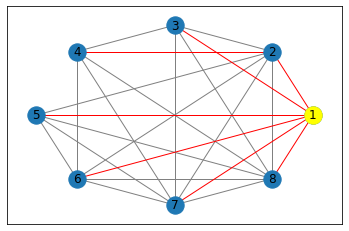

In [69]:
mst = build_rooted_mst(G, ROOT_NODE)
print("0) MST: ", mst.edges, "costo:", cost(mst, ROOT_NODE))
draw_graph(G, mst, ROOT_NODE)
plt.savefig(os.path.join(OUT_DIR,'iter_0'))

### 2. Improvement

> Possibili miglioramenti?

* TODO parametrizzare e isolare in una funzione

* ~~TODO provare con grafi grossi~~ soluzioni parecchio subottimali (con 16 nodi, c=10 quando ottimo è c=0)

* TODO preferire aggiunta di archi incidenti in nodi foglia?

In [70]:
# CICLO DI MIGLIORAMENTO

# calcolo il complementare all'MST
outer_G = G.copy()
outer_G.remove_edges_from(mst.edges)

candidates = list(outer_G.edges)
k = 0

if DEBUG_IMPROVEMENT:
    print("NON IN MST:", outer_G.edges)
    print("MST:", mst.edges)

    plt.figure(0)
    plt.title("Initial")
    draw_graph(G, mst, root_node=ROOT_NODE)
    plt.savefig( os.path.join(OUT_DIR, 'iter_{}'.format(k)) )

#draw_graph(outer_G, root_node=ROOT_NODE)

# aggiungo un arco all'MST
# ciò causerà la nascita di un ciclo nel grafo, perchè MST è sottinsieme massimale di archi senza cicli
# quindi elimino un arco del ciclo che si è venuto a creare <=> la funzione obiettivo migliora


### TEST
## PROVA 1 ITERAZIONE

new_e = candidates[4]    

#for new_e in candidates:
iter = 0
while len(candidates) > 0 and iter <= 400:
    iter += 1
    new_e = candidates.pop(0)
    cost_before = cost(mst, ROOT_NODE)

    if cost_before == 0:
        break

    if DEBUG_IMPROVEMENT:
        print("")
        print(k,") initial cost: ",cost_before)
        print("MST=", list(mst.edges))

        print("add: ",new_e)
    mst.add_edges_from([new_e])

    # loop detection
    loop_edges = nx.algorithms.cycles.find_cycle(mst)


    cost_improved = False
    # 1: eliminazione GREEDY dell'arco in più
    # scelgo la mossa che localmente mi da l'abbassamento minore di obj()
    for ce in loop_edges:
        #print(k,"MST=",mst.edges); 
        k+=1;
        cost_before = cost(mst, ROOT_NODE)
        mst.remove_edges_from([ce])
        
        if DEBUG_IMPROVEMENT:
            fig = plt.figure(k)
            plt.title("add: {}, remove: {}".format(new_e, ce))
            draw_graph(G, mst, root_node=ROOT_NODE )
            plt.savefig(os.path.join(OUT_DIR,'iter_{}'.format(k)))
            print("remove: ", ce)
            
        cost_after = cost(mst, ROOT_NODE)

        if cost_after > cost_before:
            # annulla e prova a rimuovere un altro arco
            mst.add_edges_from([ce])
            if DEBUG_IMPROVEMENT:
                print("new cost: ",cost_after, "(revert)")
        else:
            # rendi la modifica permanente e passa oltre.
            # non esploro gli altri archi candidati per lo scambio 
            # perchè con una mossa del genere
            # il costo può essere ridotto solo di 1
            if DEBUG_IMPROVEMENT:
                print("new cost: ",cost_after, "(keep)")
            cost_improved = True

            # metto l'arco rimosso nell'insieme dei candidati
            # nel caso mi serva per migliorare più avanti
            # (lo metto in fondo alla lista per evitare di rimanere bloccato)
            candidates.append(ce)


            break

        # se non ci sono stati miglioramenti, 
        # rimuovi l'arco aggiunto e provane un altro
        if not cost_improved:
            if DEBUG_IMPROVEMENT:
                print("No improvements, removing: ",new_e)
            mst.remove_edges_from([new_e])
            candidates.append(new_e)

print("iter=",iter)

iter= 11


Costo finale:  0
MST =  [(1, 8), (2, 5), (2, 6), (3, 7), (3, 8), (6, 4), (7, 4)]
---TEST AMMISSIBILITA'---
mst is tree:  True
mst loops:  None


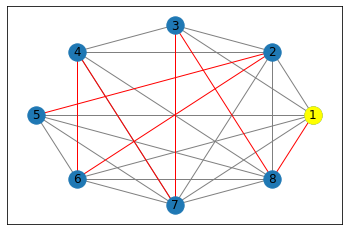

In [71]:
# PRINT RESULT
print("Costo finale: ", cost(mst, ROOT_NODE))
print("MST = ",mst.edges)
draw_graph(G, mst, ROOT_NODE)
plt.savefig(os.path.join(OUT_DIR,'iter_final'))


print("---TEST AMMISSIBILITA'---")

print("mst is tree: ",nx.is_tree(mst))

try:
    cycletest = nx.algorithms.cycles.find_cycle(mst, orientation="ignore")
except:
    cycletest = None
finally:
    print("mst loops: ", cycletest)